# Ultrasound Breast Tumour Classification Project

The following Jupyter Notebook uses the PyTorch machine learning framework to build, train, and test on a custom convolutional neural network (CNN).

The dataset used consists of images from breast ultrasound scans that are categorized into three classes depending on the tumour (or lack thereof): normal, benign, and malignant.

However, as you will notice during the data preparation segment, we will not be making use of the normal images. The model will be trained on benign and malignant classes only.

The dataset also contains mask images that segment where the tumour is. Those are not made use of in here, but rather used in other models (Mask RCNN and U-NET).

Instead, there will be two models created and trained. One on the ultrasound images, and one on the mask images.

The Notebook is divided as follows:

* Data preparation

* Setting up transforms

* Creating the Dataset and DataLoader

* Defining our model

* Creating a training and testing loop

* Instantiate our model and perform training and testing

* Evaluate and compare results

**Note**: Some of the logic seen here follows Daniel Bourke's PyTorch course, seen here: https://www.learnpytorch.io

## How to run

1. Click on `Runtime` from the bar above.
2. Click on `change runtime type`.
3. Select `GPU` as your hardware accelerator and save.
4. Connect to a runtime by clicking on `Connect` in the top right-hand side.
5. Click on `Runtime` again and `Run all`.

## Data preparation

Download data zip file.

In [ ]:
# gdown allows downloading large files from Google Drive by passing id
!gdown 1LljpoDlVfLoowaG6qAq_rCzX7W6wVjql

Downloading...
From: https://drive.google.com/uc?id=1LljpoDlVfLoowaG6qAq_rCzX7W6wVjql
To: /content/data.zip
100% 204M/204M [00:03<00:00, 65.7MB/s]


Importing all necessary libraries.

In [ ]:
import zipfile
import requests
import os
import shutil
import random
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from PIL import Image
from typing import Dict, List
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timeit import default_timer as timer

Create `data` directory and unzip contents.

In [ ]:
data_path = 'data'

if os.path.isdir(data_path):
  print("The directory already exists.")
else:
    with zipfile.ZipFile("data.zip", "r") as zip_ref:
      zip_ref.extractall("data")

The following three cells perform a similar data preperation logic.

The first is for normal scans and masks, the second for benign, and third for malignant.

* Sets paths for training and testing folders.
* Create ratio that will be used to split training and testing data.
* Fetches all the images for the specified class and shuffles them.
* Splits the images into train and test sets.
* Create the directories where we will be storing them.
* Move the train and test data to the train and test directories, respectively.

In [ ]:
# set the path to the folder containing the images
path_to_normal = 'data/ultrasound/normal'

if os.path.exists(path_to_normal):
  
  # set the path to the output folders for the train and test data
  train_normal = 'data/train/normal'
  test_normal = 'data/test/normal'

  # set the train/test split ratio
  train_ratio = 0.75

  # get a list of all image file names in the folder
  normal_image_filenames = os.listdir(path_to_normal)

  # shuffle the image filenames to ensure a random split
  random.shuffle(normal_image_filenames)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(normal_image_filenames))
  train_image_filenames = normal_image_filenames[:split_index]
  test_image_filenames = normal_image_filenames[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_normal):
      os.makedirs(train_normal)
  if not os.path.exists(test_normal):
      os.makedirs(test_normal)

  # copy the train images to the train output folder
  for filename in train_image_filenames:
      source_path = os.path.join(path_to_normal, filename)
      destination_path = os.path.join(train_normal, filename)
      shutil.copy(source_path, destination_path)

  # copy the test images to the test output folder
  for filename in test_image_filenames:
      source_path = os.path.join(path_to_normal, filename)
      destination_path = os.path.join(test_normal, filename)
      shutil.copy(source_path, destination_path)

  print(f"Finished splitting {len(normal_image_filenames)} images into train and test sets.")


Finished splitting 266 images into train and test sets.


In [ ]:
# set the path to the folders containing the images
path_to_benign = 'data/ultrasound/benign'

if os.path.exists(path_to_benign):

  # set the path to the output folders for the train and test data
  train_benign = 'data/train/benign'
  test_benign = 'data/test/benign'

  # set the train/test split ratio
  train_ratio = 0.75

  # get a list of all image file names in the folder
  benign_image_filenames = os.listdir(path_to_benign)

  # shuffle the image filenames to ensure a random split
  random.shuffle(benign_image_filenames)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(benign_image_filenames))
  train_image_filenames = benign_image_filenames[:split_index]
  test_image_filenames = benign_image_filenames[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_benign):
      os.makedirs(train_benign)
  if not os.path.exists(test_benign):
      os.makedirs(test_benign)

  # copy the train images to the train output folder
  for filename in train_image_filenames:
      source_path = os.path.join(path_to_benign, filename)
      destination_path = os.path.join(train_benign, filename)
      shutil.copy(source_path, destination_path)

  # copy the test images to the test output folder
  for filename in test_image_filenames:
      source_path = os.path.join(path_to_benign, filename)
      destination_path = os.path.join(test_benign, filename)
      shutil.copy(source_path, destination_path)

  print(f"Finished splitting {len(benign_image_filenames)} images into train and test sets.")


Finished splitting 891 images into train and test sets.


In [ ]:
# set the path to the folders containing the images
path_to_malignant = 'data/ultrasound/malignant'

if os.path.exists(path_to_malignant):

  # set the path to the output folders for the train and test data
  train_malignant = 'data/train/malignant'
  test_malignant = 'data/test/malignant'

  # set the train/test split ratio
  train_ratio = 0.75

  # get a list of all image file names in the folder
  malignant_image_filenames = os.listdir(path_to_malignant)

  # shuffle the image filenames to ensure a random split
  random.shuffle(malignant_image_filenames)

  # split the image filenames into train and test sets
  split_index = int(train_ratio * len(malignant_image_filenames))
  train_image_filenames = malignant_image_filenames[:split_index]
  test_image_filenames = malignant_image_filenames[split_index:]

  # create the train and test output folders if they don't already exist
  if not os.path.exists(train_malignant):
      os.makedirs(train_malignant)
  if not os.path.exists(test_malignant):
      os.makedirs(test_malignant)

  # copy the train images to the train output folder
  for filename in train_image_filenames:
      source_path = os.path.join(path_to_malignant, filename)
      destination_path = os.path.join(train_malignant, filename)
      shutil.copy(source_path, destination_path)

  # copy the test images to the test output folder
  for filename in test_image_filenames:
      source_path = os.path.join(path_to_malignant, filename)
      destination_path = os.path.join(test_malignant, filename)
      shutil.copy(source_path, destination_path)

  print(f"Finished splitting {len(malignant_image_filenames)} images into train and test sets.")

Finished splitting 421 images into train and test sets.


In [ ]:
# moving ultrasound dir out of 'data/' path
check_dir = 'ultrasound'

if os.path.isdir(check_dir):
  print('Dataset already moved.')
else:
  root = '/content'
  dataset = 'data/ultrasound'
  shutil.move(dataset, root)

In [ ]:
os.rename('ultrasound', 'original_data')
os.rename('data', 'mask_images')

In [ ]:
# creating a new directory to store the ultrasound images separately from the mask images
src = 'mask_images'
dst = 'ultrasound_images'

shutil.copytree(src, dst)

'ultrasound_images'

Loop through both directories we created above, and remove either the ultrasound image or mask image.

In [ ]:
path_to_data_mask = 'mask_images/'
path_to_data_ultrasound = 'ultrasound_images/'

for directory_path, directory_names, file_names in os.walk(path_to_data_mask):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" not in file_name and "normal" not in file_name:
            # remove the file if it does not contains "mask" in its filename
            os.remove(os.path.join(directory_path, file_name))

for directory_path, directory_names, file_names in os.walk(path_to_data_ultrasound):
    # loop through all image files in the current directory
    for file_name in file_names:
        if "mask" in file_name and "normal" not in file_name:
            # remove the file if it contains "mask" in its filename
            os.remove(os.path.join(directory_path, file_name))

In [ ]:
# removing the directories containing the normal scans
shutil.rmtree(path_to_data_mask + '/train/normal')
shutil.rmtree(path_to_data_mask + '/test/normal')

shutil.rmtree(path_to_data_ultrasound + '/train/normal')
shutil.rmtree(path_to_data_ultrasound + '/test/normal')

## Set up our data agumentation/transforms and create the Dataset's and DataLoader's

In [ ]:
data_transform = transforms.Compose([
    
    transforms.Resize(size=(600, 700)),
    transforms.ToTensor()

])

Using PyTorch's generic built-in ImageFolder Dataset class.

In [ ]:
# mask images

train_dir_mask = 'mask_images/train'
test_dir_mask = 'mask_images/test'

train_data_mask = datasets.ImageFolder(root=train_dir_mask,
                                  transform=data_transform) # transform for the data

test_data_mask = datasets.ImageFolder(root=test_dir_mask,
                                transform=data_transform) # transform for the data

# ultrasound images

train_dir_ultrasound = 'ultrasound_images/train'
test_dir_ultrasound = 'ultrasound_images/test'

train_data_ultrasound = datasets.ImageFolder(root=train_dir_ultrasound,
                                  transform=data_transform) # transform for the data

test_data_ultrasound = datasets.ImageFolder(root=test_dir_ultrasound,
                                  transform=data_transform) # transform for the data


In [ ]:
# get class names and class names as dictionaries

# mask images

class_names_mask = train_data_mask.classes
class_names_dict_mask = test_data_mask.class_to_idx

# ultrasound images

class_names_ultrasound = train_data_ultrasound.classes
class_names_dict_ultrasound = test_data_ultrasound.class_to_idx


Create train and test DataLoader's from Dataset's.


In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

# mask images

train_dataloader_mask = DataLoader(dataset=train_data_mask,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS # how many cpu cores (use os.cpu_count() to use all)
)

test_dataloader_mask = DataLoader(dataset=test_data_mask,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS
)

# ultrasound images

train_dataloader_ultrasound = DataLoader(dataset=train_data_ultrasound,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS
)

test_dataloader_ultrasound = DataLoader(dataset=test_data_ultrasound,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS 
)

Setting up device-agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Creating our model

Model definition

In [ ]:
class MyModel(nn.Module):
  """
  Basic CNN model architecture
  """
  def __init__(self, 
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=16, # 16 feature maps
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=16,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=16,
                  out_channels=64,
                  kernel_size=5,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=5,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*145*170, # previous output * width * height (the values here can obviously be calculated by hand by mathematically seeing what the previous layers are doing to the image, however set a random number here and do a forward pass and print the shape of the image before getting here and then update the value accordingly)
                  out_features=output_shape)
    )
    
  def forward(self, x):
    x = self.conv_block1(x)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)

    return x

## Create train and test loops functions

* `train_step()` - takes a model and dataloader and trains the model on the dataloader.

* `test_step()` - take a model and a dataloader and evaluates the model on the dataloader.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  
  # train mode
  model.train()

  # set up loss and accuracy values
  train_loss, train_acc = 0, 0

  # loop through dataloader batches
  for batch, (X, y) in enumerate(dataloader):

    # send to device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # calculate accuracy metric
    y_pred_probs = torch.softmax(y_pred, dim=1)
    y_pred_class = torch.argmax(y_pred_probs, dim=1)
    
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
  
  # eval mode
  model.eval()

  # set up loss and accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():
    
  # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):

      # send to device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred = model(X)

      # calculate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # calculate accuracy metric
      test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred)

  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

Creating a `train()` function to combine train and test loops.

In [ ]:
from tqdm.auto import tqdm

# create a train function 
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs,
          device = device):
  
   # create results dictionary
   results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}
    

    # loop through training and testing steps 
   for epoch in tqdm(range(epochs)):

     train_loss, train_acc = train_step(model,
                                        train_dataloader,
                                        loss_fn,
                                        optimizer,
                                        device)
     
     test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    device)
     
     print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

     # update results dictionary
     results["train_loss"].append(train_loss)
     results["train_acc"].append(train_acc)
     results["test_loss"].append(test_loss)
     results["test_acc"].append(test_acc)

   return results

## Train and test our model

In [ ]:
# hyperparameters
input_shape = 3
hidden_units = 10
NUM_EPOCHS = 20

Mask images training and testing

In [ ]:
mymodel_mask = MyModel(input_shape=input_shape,
                      hidden_units=hidden_units,
                      output_shape=len(train_data_mask.classes)).to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
mask_optimizer = torch.optim.Adam(params=mymodel_mask.parameters(),
                             lr=0.001,
                             weight_decay=0.01)

# timer
start_time = timer()

# train
model_1_results_mask = train(model=mymodel_mask,
                            train_dataloader=train_dataloader_mask,
                            test_dataloader=test_dataloader_mask,
                            optimizer=mask_optimizer,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS,
                            device=device)

end_time = timer()
total_time = time.strftime("%M:%S", time.gmtime(end_time - start_time))
print(f"Total training time for mask model: {total_time} minutes.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0907 | Train acc: 0.6634 | Test loss: 0.6886 | Test acc: 0.6687
Epoch: 1 | Train loss: 0.5277 | Train acc: 0.7680 | Test loss: 0.7555 | Test acc: 0.6750
Epoch: 2 | Train loss: 0.5124 | Train acc: 0.7715 | Test loss: 0.7112 | Test acc: 0.6687
Epoch: 3 | Train loss: 0.5241 | Train acc: 0.7919 | Test loss: 0.6831 | Test acc: 0.6687
Epoch: 4 | Train loss: 0.4931 | Train acc: 0.7914 | Test loss: 0.6030 | Test acc: 0.7063
Epoch: 5 | Train loss: 0.5221 | Train acc: 0.7954 | Test loss: 0.8632 | Test acc: 0.7188
Epoch: 6 | Train loss: 0.5344 | Train acc: 0.7609 | Test loss: 0.6579 | Test acc: 0.6937
Epoch: 7 | Train loss: 0.5244 | Train acc: 0.7697 | Test loss: 0.7134 | Test acc: 0.6687
Epoch: 8 | Train loss: 0.4916 | Train acc: 0.7695 | Test loss: 0.6025 | Test acc: 0.6875
Epoch: 9 | Train loss: 0.4606 | Train acc: 0.8016 | Test loss: 0.6748 | Test acc: 0.6813
Epoch: 10 | Train loss: 0.4714 | Train acc: 0.7954 | Test loss: 0.6580 | Test acc: 0.6562
Epoch: 11 | Train lo

Ultrasound images training and testing

In [ ]:
mymodel_ultrasound = MyModel(input_shape=input_shape,
                            hidden_units=hidden_units,
                            output_shape=len(train_data_ultrasound.classes)).to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
ultrasound_optimizer = torch.optim.Adam(params=mymodel_ultrasound.parameters(),
                             lr=0.001,
                             weight_decay=0.01)
                  
# timer
start_time = timer()

# train
model_1_results_ultrasound = train(model=mymodel_ultrasound,
                                  train_dataloader=train_dataloader_ultrasound,
                                  test_dataloader=test_dataloader_ultrasound,
                                  optimizer=ultrasound_optimizer,
                                  loss_fn=loss_fn,
                                  epochs=NUM_EPOCHS,
                                  device=device)

end_time = timer()
total_time = time.strftime("%M:%S", time.gmtime(end_time - start_time))
print(f"Total training time for ultrasound model: {total_time} minutes.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4943 | Train acc: 0.6426 | Test loss: 0.8888 | Test acc: 0.6591
Epoch: 1 | Train loss: 0.6063 | Train acc: 0.7006 | Test loss: 0.4896 | Test acc: 0.7961
Epoch: 2 | Train loss: 0.5667 | Train acc: 0.7235 | Test loss: 0.5269 | Test acc: 0.7563
Epoch: 3 | Train loss: 0.5343 | Train acc: 0.7613 | Test loss: 0.4812 | Test acc: 0.7708
Epoch: 4 | Train loss: 0.5229 | Train acc: 0.7551 | Test loss: 0.6493 | Test acc: 0.7487
Epoch: 5 | Train loss: 0.6017 | Train acc: 0.7098 | Test loss: 0.5105 | Test acc: 0.7917
Epoch: 6 | Train loss: 0.4659 | Train acc: 0.7911 | Test loss: 0.4781 | Test acc: 0.7942
Epoch: 7 | Train loss: 0.5132 | Train acc: 0.7384 | Test loss: 0.5033 | Test acc: 0.7658
Epoch: 8 | Train loss: 0.4141 | Train acc: 0.8205 | Test loss: 0.4650 | Test acc: 0.7860
Epoch: 9 | Train loss: 0.4115 | Train acc: 0.8116 | Test loss: 0.5323 | Test acc: 0.7746
Epoch: 10 | Train loss: 0.3256 | Train acc: 0.8622 | Test loss: 0.6331 | Test acc: 0.7424
Epoch: 11 | Train lo

## Saving our model for later use if needed

In [ ]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    model.load_state_dict(checkpoint["state_dict"])

In [ ]:
mask_state = {
    "state_dict": mymodel_mask.state_dict(),
    "optimizer": mask_optimizer.state_dict()
}

ultrasound_state = {
    "state_dict": mymodel_ultrasound.state_dict(),
    "optimizer": ultrasound_optimizer.state_dict()
}

save_checkpoint(mask_state, "MyModel_Mask.pth")
save_checkpoint(ultrasound_state, "MyModel_Ultrasound.pth")

In [ ]:
model = MyModel(input_shape=3,
                hidden_units=10,
                output_shape=2).to(device)
filename = "MyModel_Ultrasound.pth"
load_checkpoint(torch.load(filename), model)

## Evaluation and compare model results


In [ ]:
def plot_loss_curves(results: Dict[str, List[float]], title):
  """
  Plots a training curve of a results dictionary
  """

  # get loss values of dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get accuracy values of dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # how many epochs
  epochs = range(len(results["train_loss"]))

  # set up plot and title
  plt.figure(figsize=(15, 7))
  plt.suptitle(title)

  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


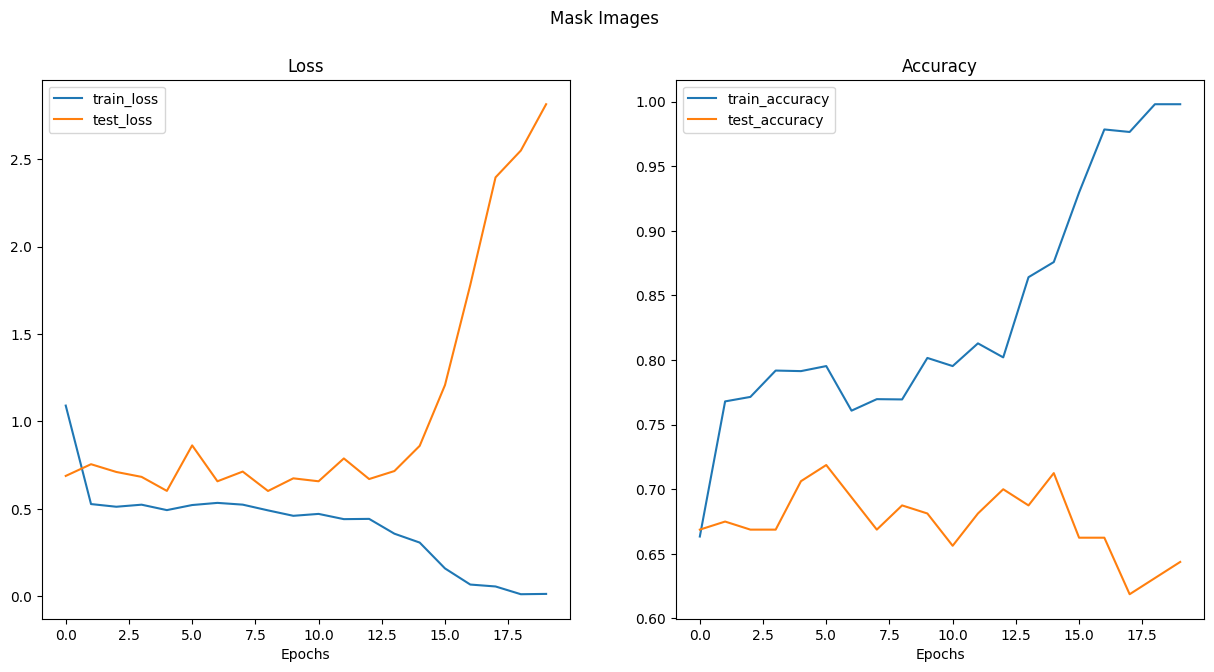

In [ ]:
plot_loss_curves(model_1_results_mask, "Mask Images")

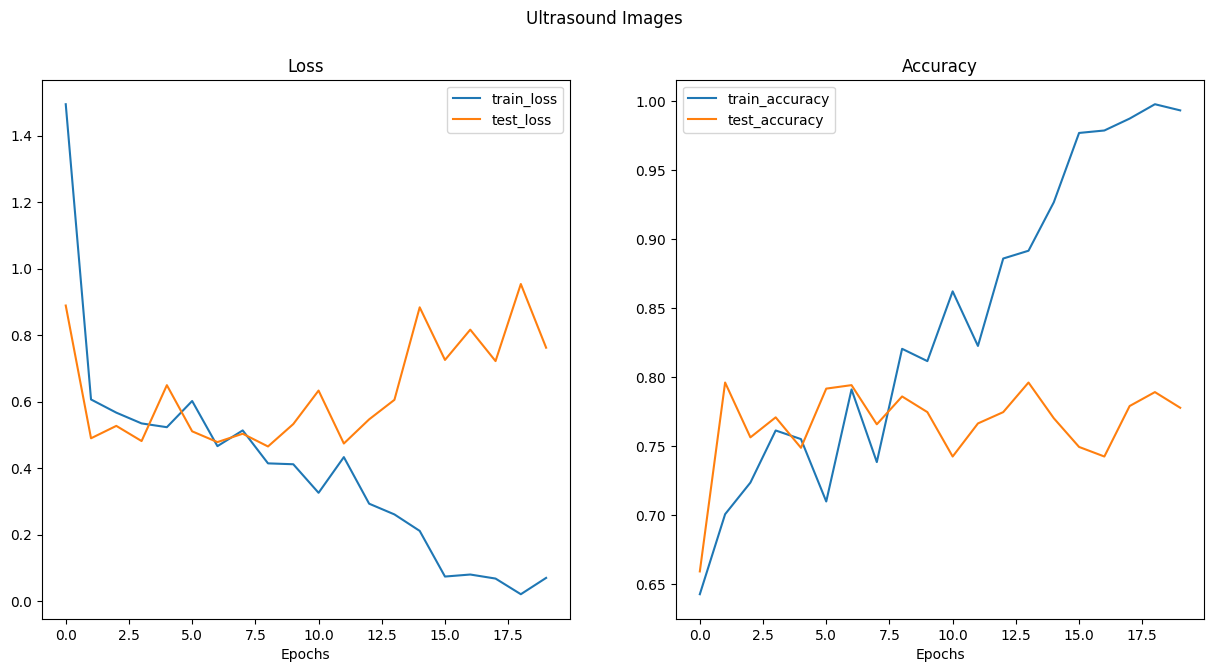

In [ ]:
plot_loss_curves(model_1_results_ultrasound, "Ultrasound Images")

In [ ]:
mask_df = pd.DataFrame(model_1_results_mask)
ultrasound_df = pd.DataFrame(model_1_results_ultrasound)

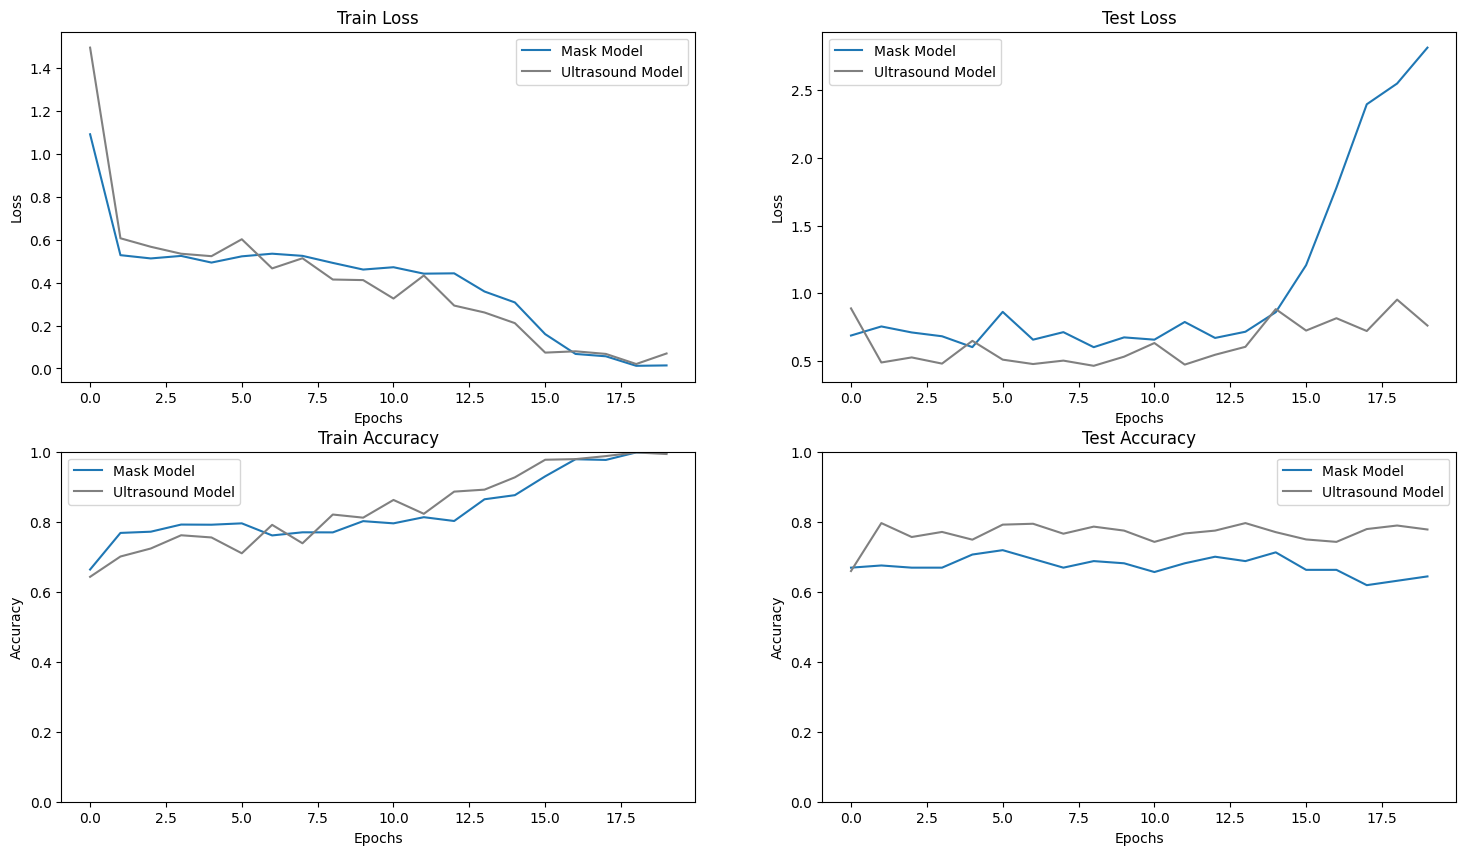

In [ ]:
# set up plot
plt.figure(figsize=(18, 10))

# get number of epochs
epochs = range(len(mask_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, mask_df["train_loss"], label="Mask Model")
plt.plot(epochs, ultrasound_df["train_loss"], label="Ultrasound Model", color='grey')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, mask_df["test_loss"], label="Mask Model")
plt.plot(epochs, ultrasound_df["test_loss"], label="Ultrasound Model", color='grey')
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, mask_df["train_acc"], label="Mask Model")
plt.plot(epochs, ultrasound_df["train_acc"], label="Ultrasound Model", color='grey')
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.legend()

# plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, mask_df["test_acc"], label="Mask Model")
plt.plot(epochs, ultrasound_df["test_acc"], label="Ultrasound Model", color='grey')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.legend()

## Using our model to predict on a custom image

In [ ]:
import requests
from io import BytesIO
import torchvision

# fetch custom image (malignant)
response = requests.get('https://prod-images-static.radiopaedia.org/images/2367196/28cf3593e1270d0c73c02c27db7b4f_big_gallery.JPG')
img = Image.open(BytesIO(response.content))

In [ ]:
# converting the PIL image to a tensor
tensor_uint8 = torchvision.transforms.functional.pil_to_tensor(img)

# converting our image to torch.float32 AND dividing by 255 to make all our values range from 0 to 1
custom_image = tensor_uint8.type(torch.float32) / 255.

In [ ]:
# resize image using transform
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(600, 700))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 467, 630])
Transformed shape: torch.Size([3, 600, 700])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# add a batch size
custom_image_transformed = custom_image_transformed.unsqueeze(0)

In [ ]:
# forward pass on model

model.eval()
with torch.inference_mode():
  custom_image_pred = model(custom_image_transformed.to(device))

In [ ]:
custom_image_pred

tensor([[-0.3052,  0.2932]], device='cuda:0')

In [ ]:
# logits to prediction probabilities

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3547, 0.6453]], device='cuda:0')

In [ ]:
# prediction probabilities to prediction labels

custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([1], device='cuda:0')

Now we can finally index our class names dictionary and output the predicted class. In this case, it is benign.

In [ ]:
class_names_ultrasound[custom_image_pred_labels]

'malignant'

## Using a pre-trained model

If you would like to use a pre-trained model instead of training one, then please follow the steps:

* Copy the model's `.pth` file to Google Colab's root files directory.

* After it has finished uploading, run the [Data preparation](#scrollTo=25MmDeuMf_bp) code cells to import all required libraries and set up the data properly.

* Then, go to the [model definition here](#scrollTo=M-d-PLRESQUg&line=4&uniqifier=1) and run to set up the model.

* Afterwards, set the `LOAD_MODEL` bool below to true and run the code cell to load the model.

* When the model has finished loading, run the cells within the following code blocks:

  * [Set up our data agumentation/transforms and create the Dataset's and DataLoader's](#scrollTo=5E0QXiqbnC2-)
  * [Using our model to predict on a custom image](#scrollTo=QiKhj-4G0UGN)

In [ ]:
LOAD_MODEL = False

def load_checkpoint(checkpoint, model):
    model.load_state_dict(checkpoint["state_dict"])

if LOAD_MODEL:
  model = MyModel(input_shape=3,
                  hidden_units=20,
                  output_shape=3).to(device)
  filename = "MyModel_Ultrasound.pth"
  load_checkpoint(torch.load(filename), model)